### Data Preparation 

Preparing data for training 

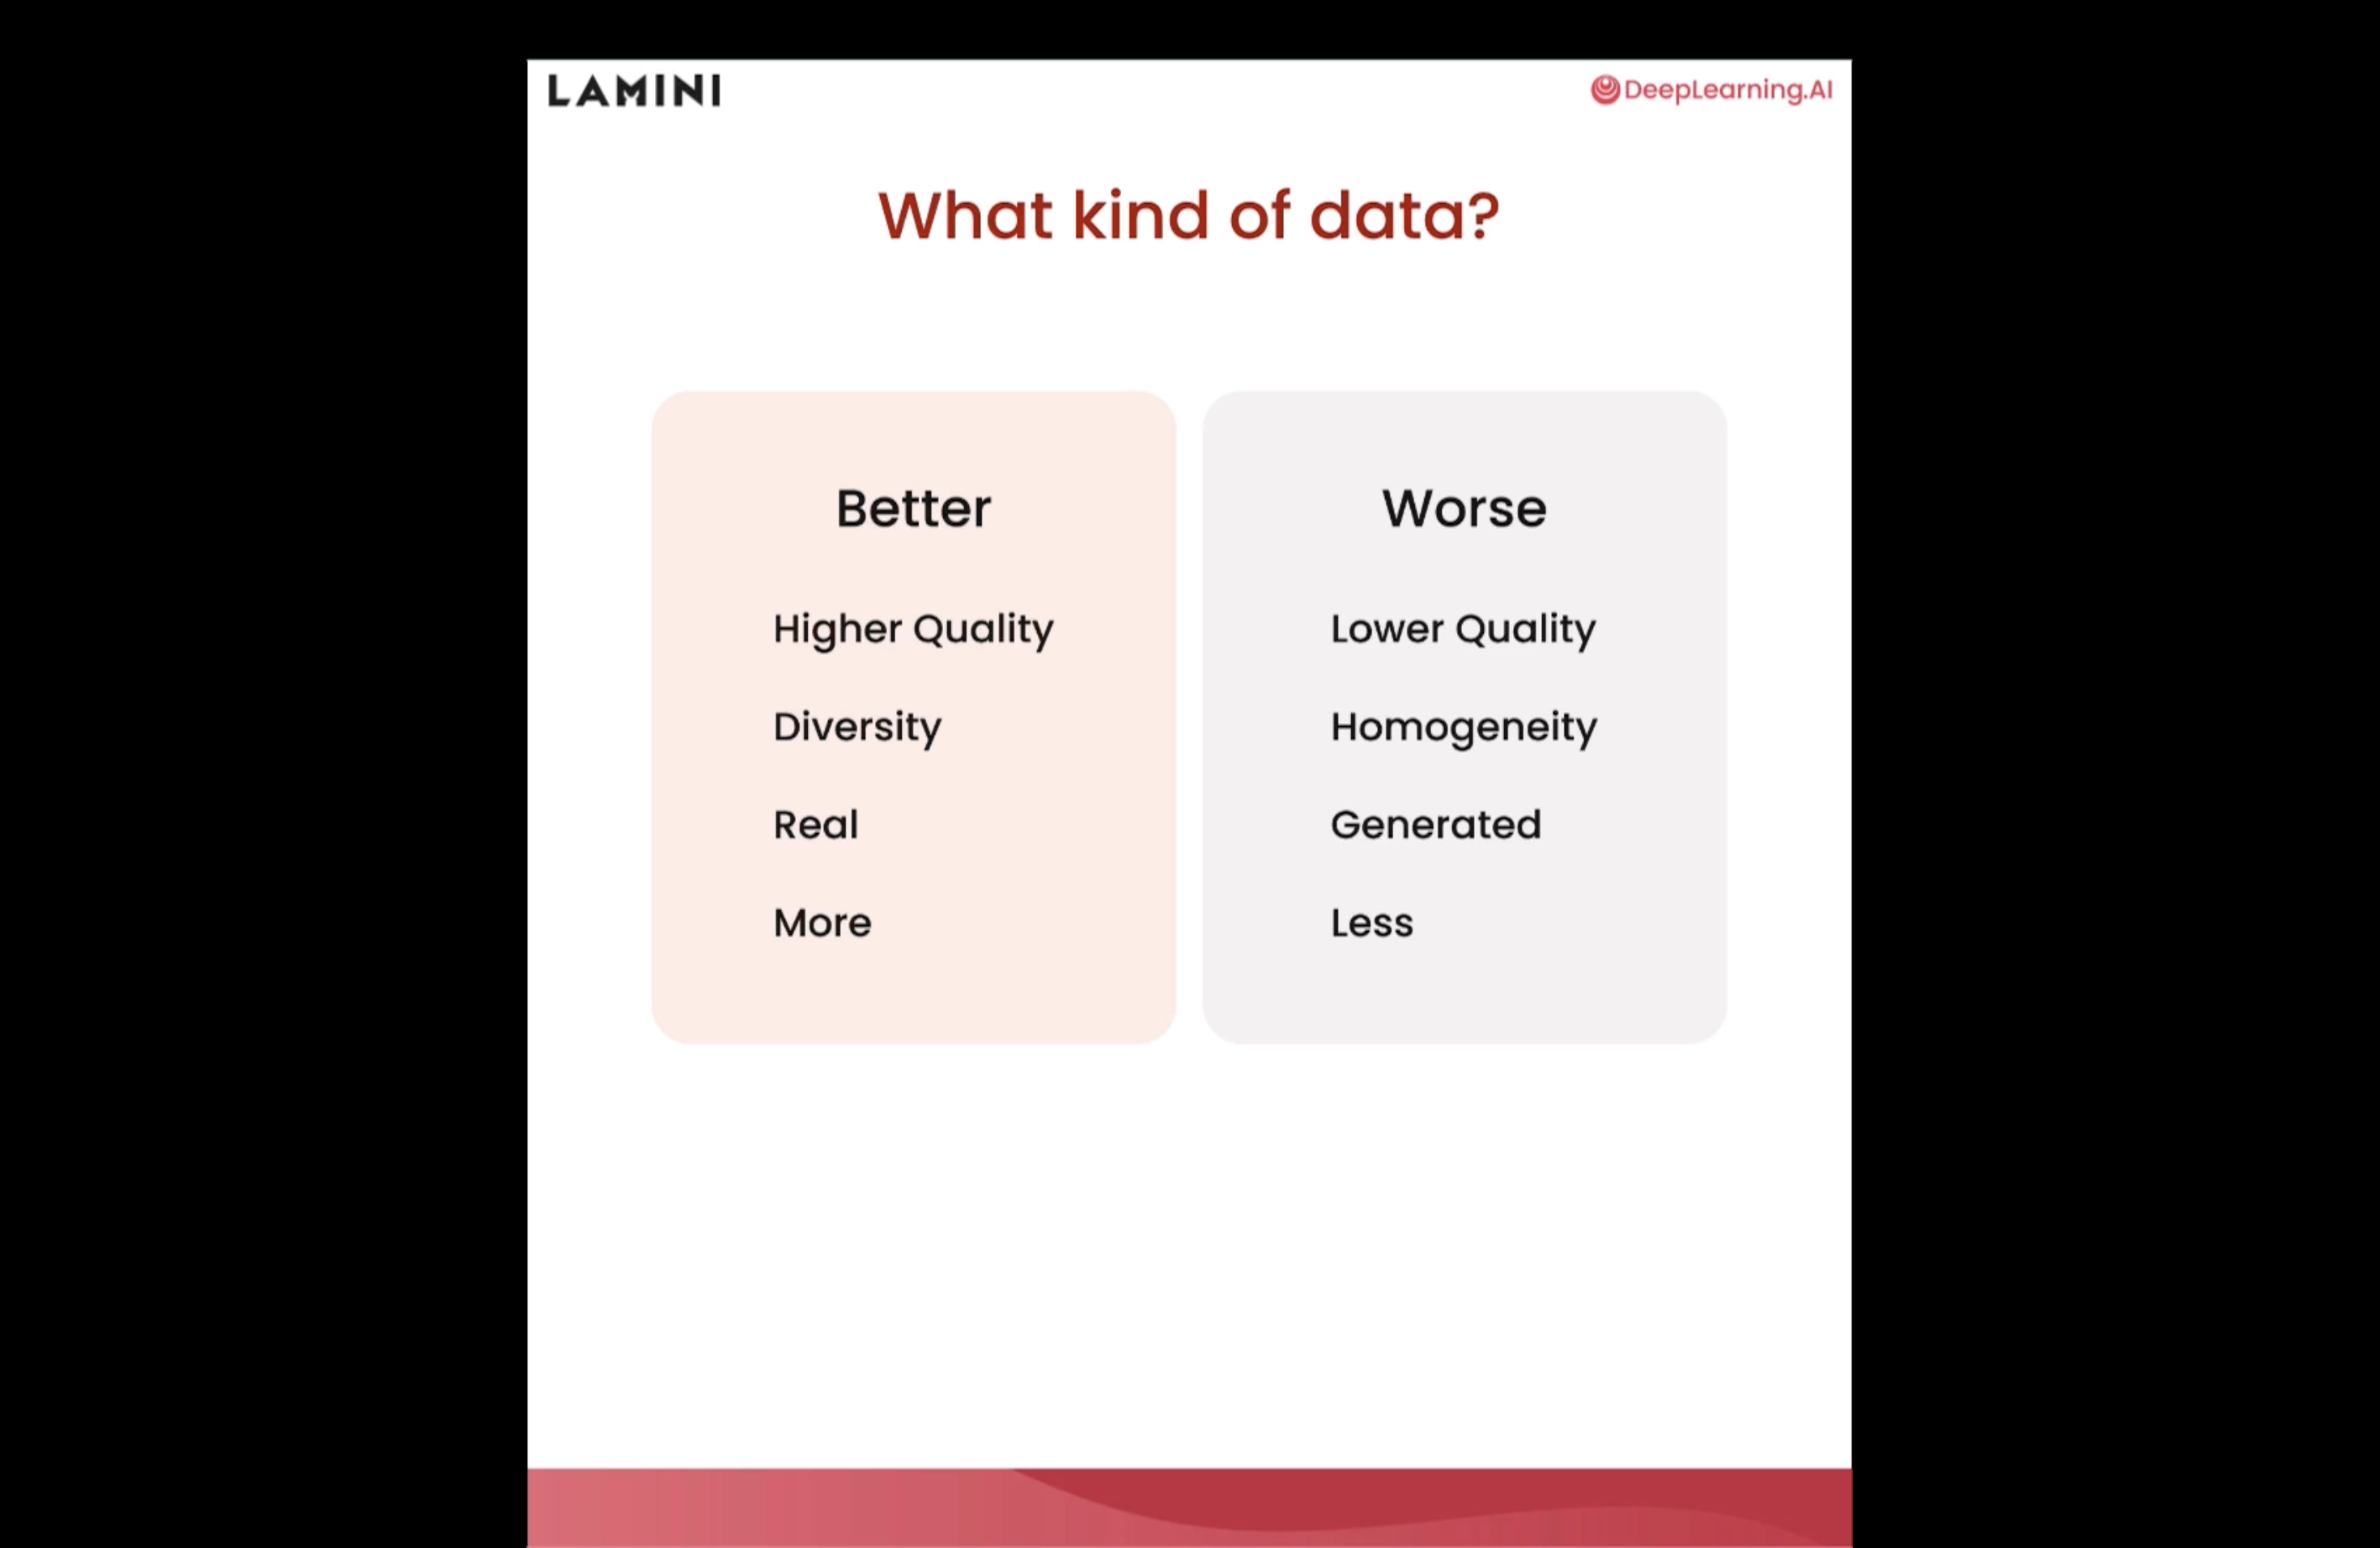

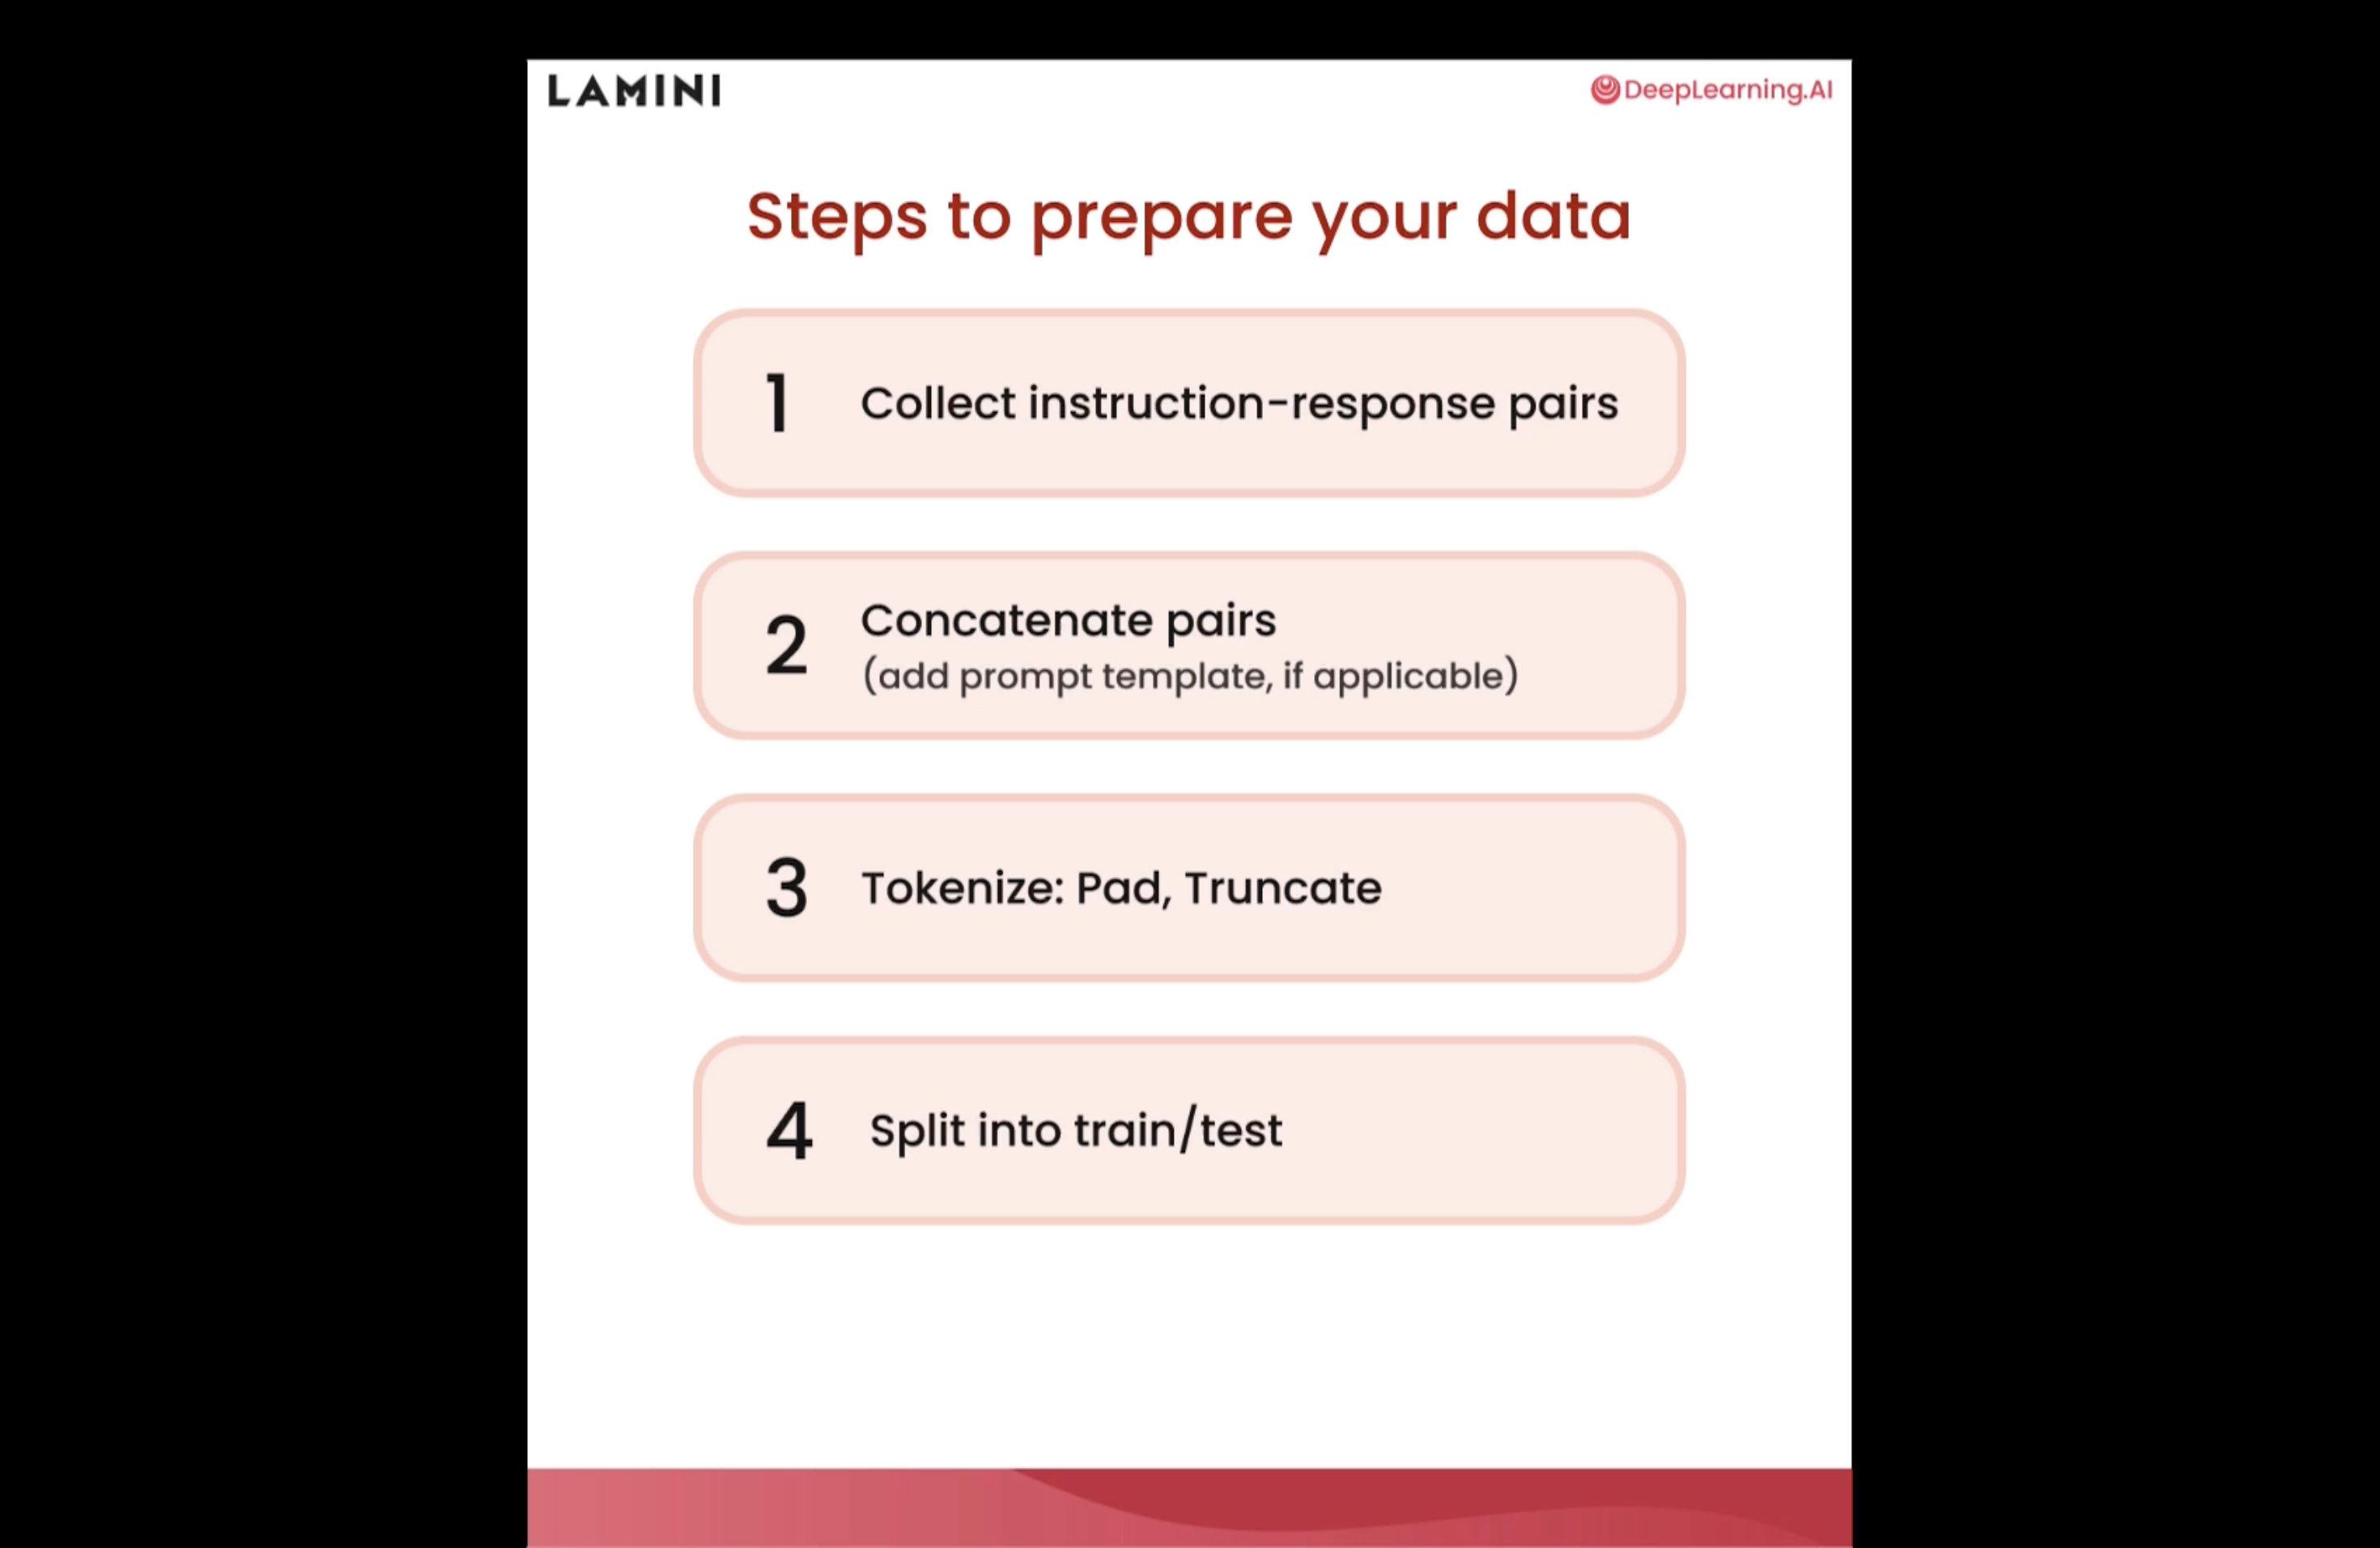

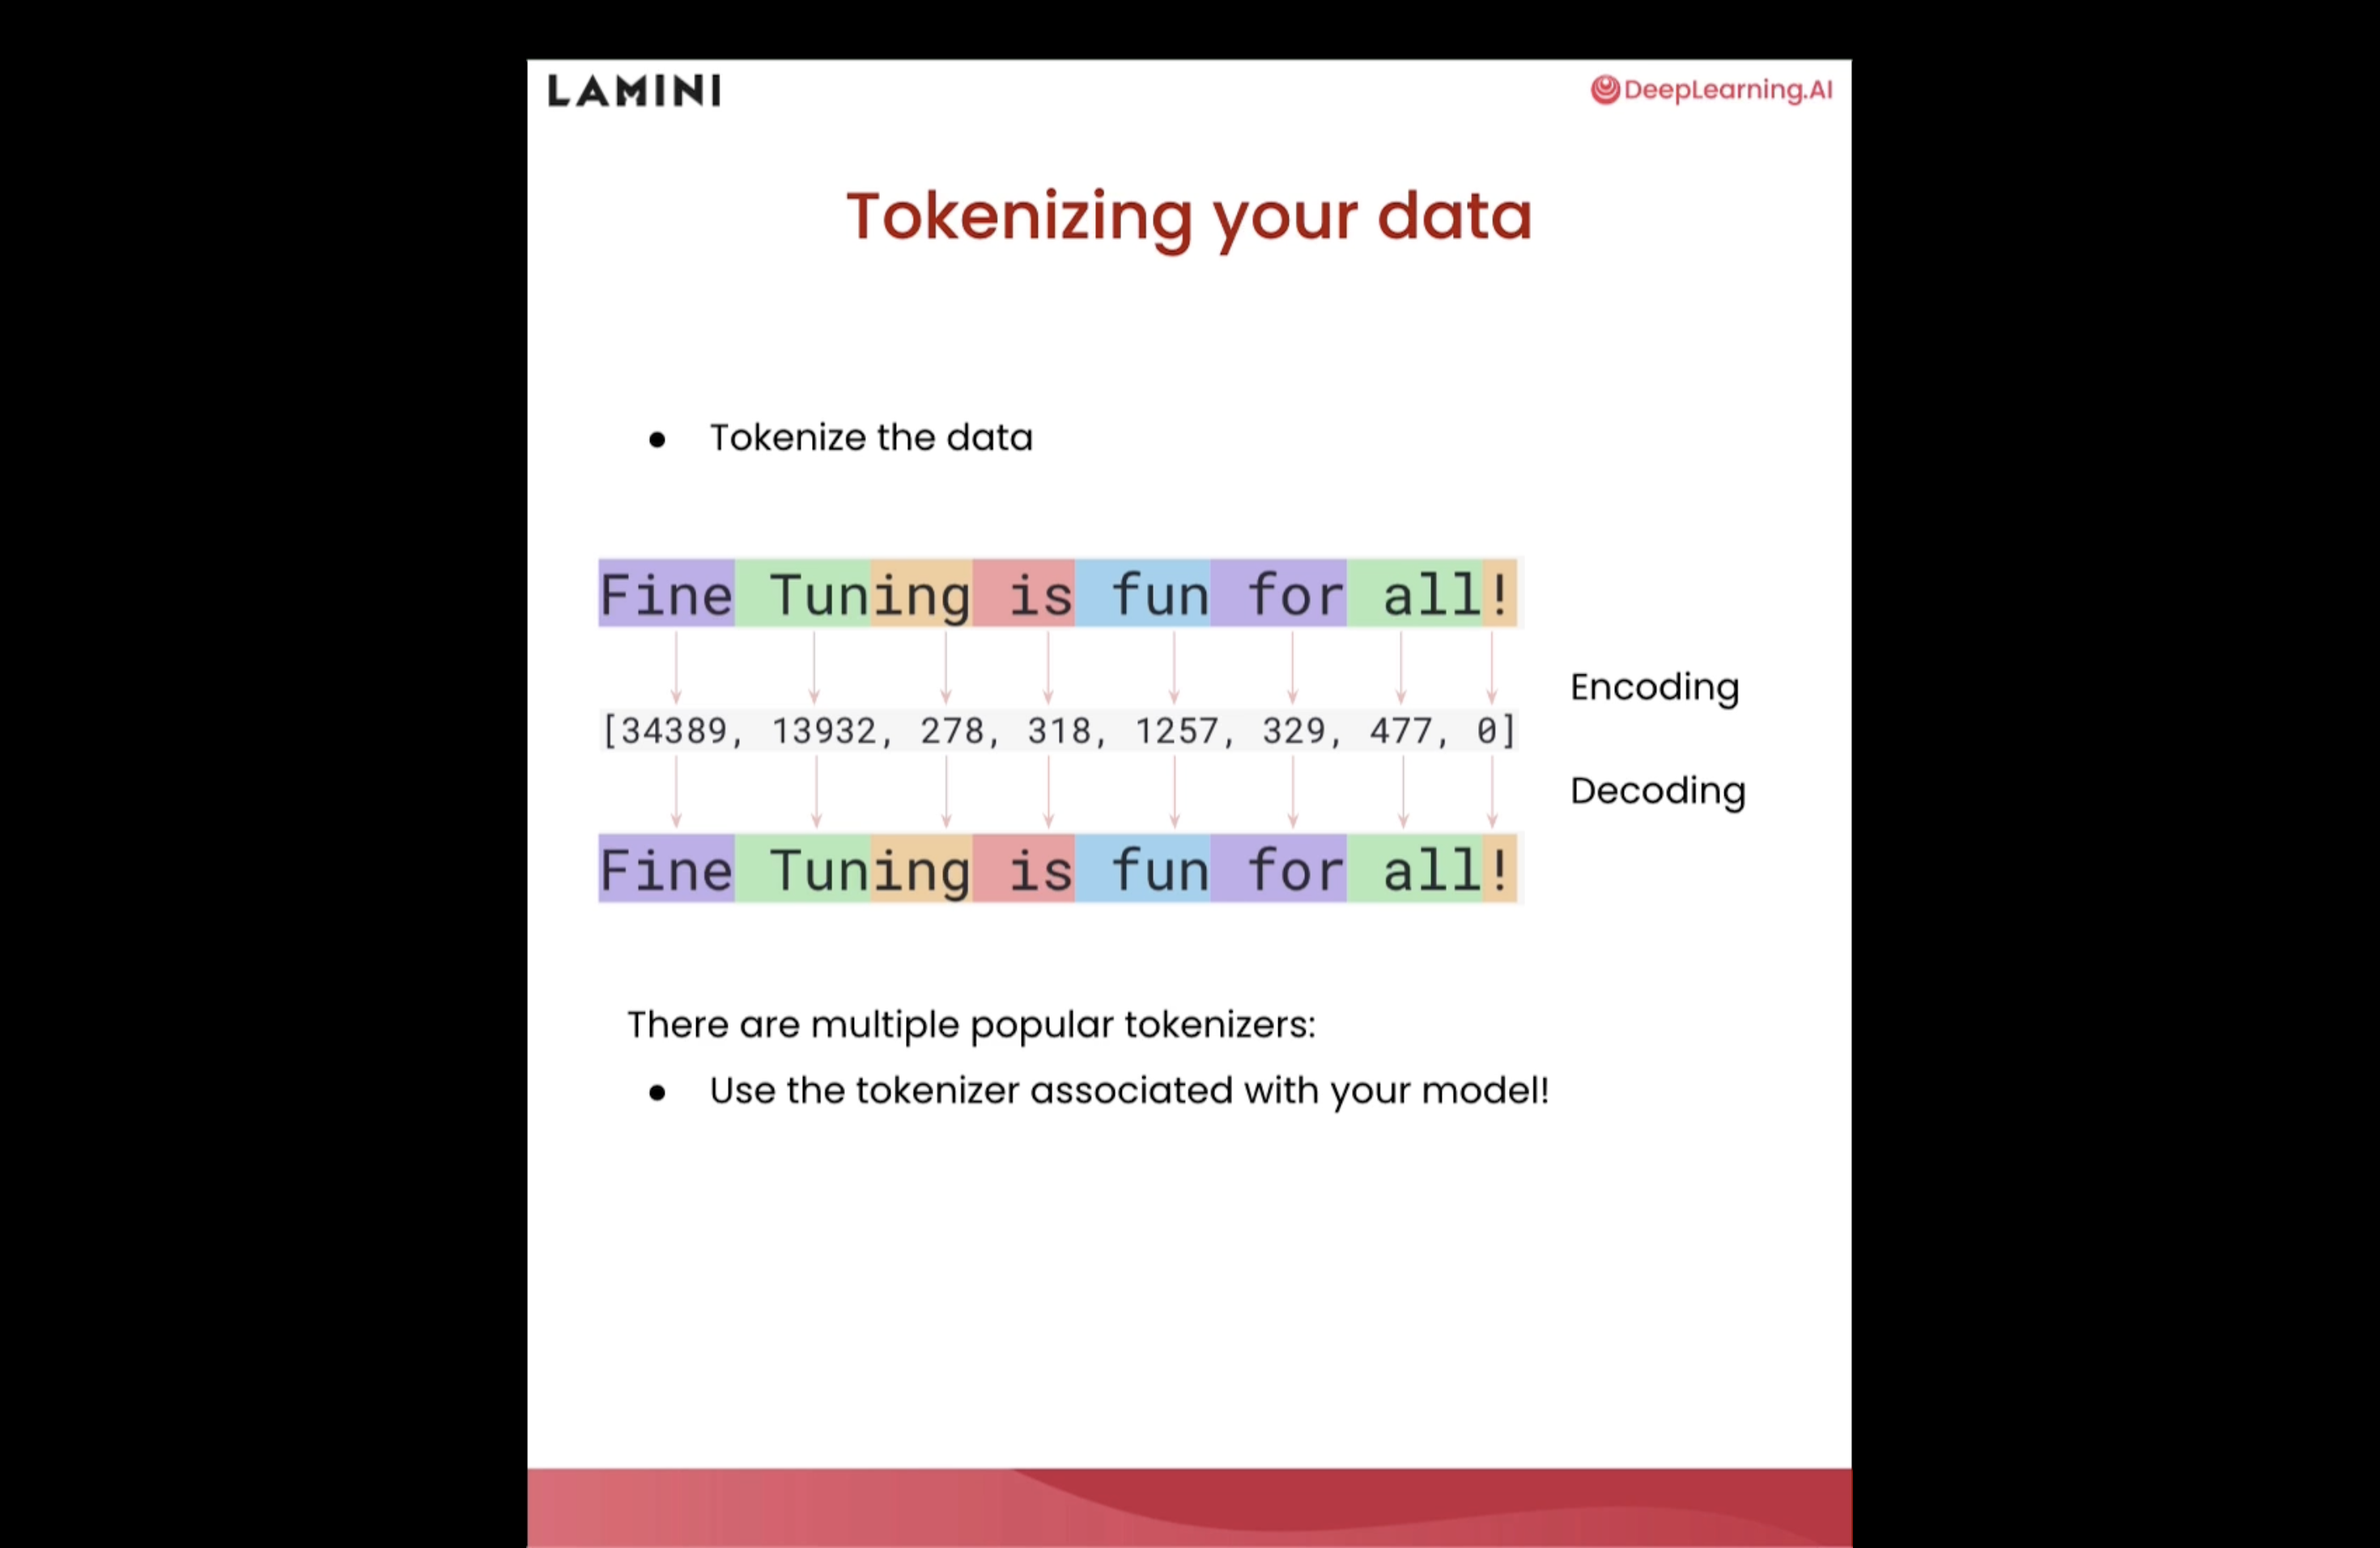

In [1]:
import pandas as pd
import datasets

from pprint import pprint
from transformers import AutoTokenizer
### AutoTokenizer will automatically use right tokenizer based on model you specify

/Users/mfho-27019739/Desktop/AIML/Github/LLM/.venv/lib/python3.9/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [3]:
tokenizer = AutoTokenizer.from_pretrained("EleutherAI/pythia-70m")
text = "Hi, how are you?"
encoded_text = tokenizer(text)["input_ids"]
encoded_text

[12764, 13, 849, 403, 368, 32]

In [4]:
decoded_text = tokenizer.decode(encoded_text)
print("Decoded tokens back into text: ", decoded_text)

Decoded tokens back into text:  Hi, how are you?


#### Tokenize multiple texts at once

In [5]:
list_texts = ["Hi, how are you?", "I'm good", "Yes"]
encoded_texts = tokenizer(list_texts)
print("Encoded several texts: ", encoded_texts["input_ids"])

Encoded several texts:  [[12764, 13, 849, 403, 368, 32], [42, 1353, 1175], [4374]]


#### Padding and truncation

In [6]:
tokenizer.pad_token = tokenizer.eos_token 
encoded_texts_longest = tokenizer(list_texts, padding=True)
print("Using padding: ", encoded_texts_longest["input_ids"])

Using padding:  [[12764, 13, 849, 403, 368, 32], [42, 1353, 1175, 0, 0, 0], [4374, 0, 0, 0, 0, 0]]


In [7]:
encoded_texts_truncation = tokenizer(list_texts, max_length=3, truncation=True)
print("Using truncation: ", encoded_texts_truncation["input_ids"])

Using truncation:  [[12764, 13, 849], [42, 1353, 1175], [4374]]


In [8]:
tokenizer.truncation_side = "left"
encoded_texts_truncation_left = tokenizer(list_texts, max_length=3, truncation=True)
print("Using left-side truncation: ", encoded_texts_truncation_left["input_ids"])

Using left-side truncation:  [[403, 368, 32], [42, 1353, 1175], [4374]]


In [9]:
encoded_texts_both = tokenizer(list_texts, max_length=3, truncation=True, padding=True)
print("Using both padding and truncation: ", encoded_texts_both["input_ids"])

Using both padding and truncation:  [[403, 368, 32], [42, 1353, 1175], [4374, 0, 0]]


#### Prepare instruction dataset

In [17]:
import pandas as pd
from datasets import load_dataset

dataset = load_dataset("kotzeje/lamini_docs.jsonl")
examples = dataset['train']

In [23]:

if "question" in examples and "answer" in examples:
  text = examples["question"][0] + examples["answer"][0]
elif "instruction" in examples and "response" in examples:
  text = examples["instruction"][0] + examples["response"][0]
elif "input" in examples and "output" in examples:
  text = examples["input"][0] + examples["output"][0]
else:
  #text = examples["text"][0]
  pass

prompt_template = """### Question:
{question}

### Answer:"""

num_examples = len(examples["question"])
finetuning_dataset = []
for i in range(num_examples):
  question = examples["question"][i]
  answer = examples["answer"][i]
  text_with_prompt_template = prompt_template.format(question=question)
  finetuning_dataset.append({"question": text_with_prompt_template, "answer": answer})

from pprint import pprint
print("One datapoint in the finetuning dataset:")
pprint(finetuning_dataset[0])

One datapoint in the finetuning dataset:
{'answer': 'There are several metrics that can be used to evaluate the '
           'performance and quality of generated text from Lamini models, '
           'including perplexity, BLEU score, and human evaluation. Perplexity '
           'measures how well the model predicts the next word in a sequence, '
           'while BLEU score measures the similarity between the generated '
           'text and a reference text. Human evaluation involves having human '
           'judges rate the quality of the generated text based on factors '
           'such as coherence, fluency, and relevance. It is recommended to '
           'use a combination of these metrics for a comprehensive evaluation '
           "of the model's performance.",
 'question': '### Question:\n'
             'How can I evaluate the performance and quality of the generated '
             'text from Lamini models?\n'
             '\n'
             '### Answer:'}


### Tokenize a single example

In [24]:
## Combining Question and answer
text = finetuning_dataset[0]["question"] + finetuning_dataset[0]["answer"]
tokenized_inputs = tokenizer(
    text,
    return_tensors="np",
    padding=True
)
print(tokenized_inputs["input_ids"])

[[ 4118 19782    27   187  2347   476   309  7472   253  3045   285  3290
    273   253  4561  2505   432   418  4988    74  3210    32   187   187
   4118 37741    27  2512   403  2067 17082   326   476   320   908   281
   7472   253  3045   285  3290   273  4561  2505   432   418  4988    74
   3210    13  1690 44229   414    13   378  1843    54  4868    13   285
   1966  7103    15  3545 12813   414  5593   849   973   253  1566 26295
    253  1735  3159   275   247  3425    13  1223   378  1843    54  4868
   5593   253 14259   875   253  4561  2505   285   247  3806  2505    15
   8801  7103  8687  1907  1966 16006  2281   253  3290   273   253  4561
   2505  1754   327  2616   824   347 25253    13  2938  1371    13   285
  17200    15   733   310  8521   281   897   247  5019   273   841 17082
    323   247 11088  7103   273   253  1566   434  3045    15]]


In [25]:
max_length = 2048
max_length = min(
    tokenized_inputs["input_ids"].shape[1],
    max_length,
)

tokenized_inputs = tokenizer(
    text,
    return_tensors="np",
    truncation=True,
    max_length=max_length
)

tokenized_inputs["input_ids"]

array([[ 4118, 19782,    27,   187,  2347,   476,   309,  7472,   253,
         3045,   285,  3290,   273,   253,  4561,  2505,   432,   418,
         4988,    74,  3210,    32,   187,   187,  4118, 37741,    27,
         2512,   403,  2067, 17082,   326,   476,   320,   908,   281,
         7472,   253,  3045,   285,  3290,   273,  4561,  2505,   432,
          418,  4988,    74,  3210,    13,  1690, 44229,   414,    13,
          378,  1843,    54,  4868,    13,   285,  1966,  7103,    15,
         3545, 12813,   414,  5593,   849,   973,   253,  1566, 26295,
          253,  1735,  3159,   275,   247,  3425,    13,  1223,   378,
         1843,    54,  4868,  5593,   253, 14259,   875,   253,  4561,
         2505,   285,   247,  3806,  2505,    15,  8801,  7103,  8687,
         1907,  1966, 16006,  2281,   253,  3290,   273,   253,  4561,
         2505,  1754,   327,  2616,   824,   347, 25253,    13,  2938,
         1371,    13,   285, 17200,    15,   733,   310,  8521,   281,
      

Now we will write in one function . SO that we can run it in whole dataset

In [26]:
def tokenize_function(examples):
    if "question" in examples and "answer" in examples:
      text = examples["question"][0] + examples["answer"][0]
    elif "input" in examples and "output" in examples:
      text = examples["input"][0] + examples["output"][0]
    else:
      text = examples["text"][0]

    tokenizer.pad_token = tokenizer.eos_token
    tokenized_inputs = tokenizer(
        text,
        return_tensors="np",
        padding=True,
    )

    max_length = min(
        tokenized_inputs["input_ids"].shape[1],
        2048
    )
    tokenizer.truncation_side = "left"
    tokenized_inputs = tokenizer(
        text,
        return_tensors="np",
        truncation=True,
        max_length=max_length
    )

    return tokenized_inputs

In [34]:

finetuning_dataset_loaded = load_dataset("kotzeje/lamini_docs.jsonl",split='train')

tokenized_dataset = finetuning_dataset_loaded.map(
    tokenize_function,
    batched=True,
    batch_size=1,
    drop_last_batch=True
)

print(tokenized_dataset)

Map:   0%|          | 0/1400 [00:00<?, ? examples/s]

Dataset({
    features: ['question', 'answer', 'input_ids', 'attention_mask'],
    num_rows: 1400
})


In [35]:
tokenized_dataset[0]

{'question': 'How can I evaluate the performance and quality of the generated text from Lamini models?',
 'answer': "There are several metrics that can be used to evaluate the performance and quality of generated text from Lamini models, including perplexity, BLEU score, and human evaluation. Perplexity measures how well the model predicts the next word in a sequence, while BLEU score measures the similarity between the generated text and a reference text. Human evaluation involves having human judges rate the quality of the generated text based on factors such as coherence, fluency, and relevance. It is recommended to use a combination of these metrics for a comprehensive evaluation of the model's performance.",
 'input_ids': [2347,
  476,
  309,
  7472,
  253,
  3045,
  285,
  3290,
  273,
  253,
  4561,
  2505,
  432,
  418,
  4988,
  74,
  3210,
  32,
  2512,
  403,
  2067,
  17082,
  326,
  476,
  320,
  908,
  281,
  7472,
  253,
  3045,
  285,
  3290,
  273,
  4561,
  2505,
  43

In [36]:
tokenized_dataset = tokenized_dataset.add_column("labels", tokenized_dataset["input_ids"])
tokenized_dataset[0]

{'question': 'How can I evaluate the performance and quality of the generated text from Lamini models?',
 'answer': "There are several metrics that can be used to evaluate the performance and quality of generated text from Lamini models, including perplexity, BLEU score, and human evaluation. Perplexity measures how well the model predicts the next word in a sequence, while BLEU score measures the similarity between the generated text and a reference text. Human evaluation involves having human judges rate the quality of the generated text based on factors such as coherence, fluency, and relevance. It is recommended to use a combination of these metrics for a comprehensive evaluation of the model's performance.",
 'input_ids': [2347,
  476,
  309,
  7472,
  253,
  3045,
  285,
  3290,
  273,
  253,
  4561,
  2505,
  432,
  418,
  4988,
  74,
  3210,
  32,
  2512,
  403,
  2067,
  17082,
  326,
  476,
  320,
  908,
  281,
  7472,
  253,
  3045,
  285,
  3290,
  273,
  4561,
  2505,
  43

In [37]:
tokenized_dataset

Dataset({
    features: ['question', 'answer', 'input_ids', 'attention_mask', 'labels'],
    num_rows: 1400
})

In [38]:
tokenized_dataset['labels']

[[2347,
  476,
  309,
  7472,
  253,
  3045,
  285,
  3290,
  273,
  253,
  4561,
  2505,
  432,
  418,
  4988,
  74,
  3210,
  32,
  2512,
  403,
  2067,
  17082,
  326,
  476,
  320,
  908,
  281,
  7472,
  253,
  3045,
  285,
  3290,
  273,
  4561,
  2505,
  432,
  418,
  4988,
  74,
  3210,
  13,
  1690,
  44229,
  414,
  13,
  378,
  1843,
  54,
  4868,
  13,
  285,
  1966,
  7103,
  15,
  3545,
  12813,
  414,
  5593,
  849,
  973,
  253,
  1566,
  26295,
  253,
  1735,
  3159,
  275,
  247,
  3425,
  13,
  1223,
  378,
  1843,
  54,
  4868,
  5593,
  253,
  14259,
  875,
  253,
  4561,
  2505,
  285,
  247,
  3806,
  2505,
  15,
  8801,
  7103,
  8687,
  1907,
  1966,
  16006,
  2281,
  253,
  3290,
  273,
  253,
  4561,
  2505,
  1754,
  327,
  2616,
  824,
  347,
  25253,
  13,
  2938,
  1371,
  13,
  285,
  17200,
  15,
  733,
  310,
  8521,
  281,
  897,
  247,
  5019,
  273,
  841,
  17082,
  323,
  247,
  11088,
  7103,
  273,
  253,
  1566,
  434,
  3045,
  15],
 [5804,
 

### Prepare test/train splits

In [39]:
split_dataset = tokenized_dataset.train_test_split(test_size=0.1, shuffle=True, seed=123)
print(split_dataset)

DatasetDict({
    train: Dataset({
        features: ['question', 'answer', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 1260
    })
    test: Dataset({
        features: ['question', 'answer', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 140
    })
})


### Some datasets for you to try

In [40]:
## We have already deployed on lamini by following above process

finetuning_dataset_path = "lamini/lamini_docs"
finetuning_dataset = datasets.load_dataset(finetuning_dataset_path)
print(finetuning_dataset)

DatasetDict({
    train: Dataset({
        features: ['question', 'answer', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 1260
    })
    test: Dataset({
        features: ['question', 'answer', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 140
    })
})


In [41]:
taylor_swift_dataset = "lamini/taylor_swift"
bts_dataset = "lamini/bts"
open_llms = "lamini/open_llms"

In [42]:
dataset_swiftie = datasets.load_dataset(taylor_swift_dataset)
print(dataset_swiftie["train"][1])

Extracting data files:   0%|          | 0/2 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/783 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/87 [00:00<?, ? examples/s]

{'question': 'What is the most popular Taylor Swift song among millennials? How does this song relate to the millennial generation? What is the significance of this song in the millennial culture?', 'answer': 'Taylor Swift\'s "Shake It Off" is the most popular song among millennials. This song relates to the millennial generation as it is an anthem of self-acceptance and embracing one\'s individuality. The song\'s message of not letting others bring you down and to just dance it off resonates with the millennial culture, which is often characterized by a strong sense of individuality and a rejection of societal norms. Additionally, the song\'s upbeat and catchy melody makes it a perfect fit for the millennial generation, which is known for its love of pop music.', 'input_ids': [1276, 310, 253, 954, 4633, 11276, 24619, 4498, 2190, 24933, 8075, 32, 1359, 1057, 436, 4498, 14588, 281, 253, 24933, 451, 5978, 32, 1737, 310, 253, 8453, 273, 436, 4498, 275, 253, 24933, 451, 4466, 32, 37979, 24